# Lab 5-2: Flood Probability
---
For multiple applications (flood insurance, risk analysis), we need to know the probability of a given location flooding in any year.  To do this we look at historic floods, assume a probability distribution, and then use both to estimate the magnitude of a flood with a certain return period or the return period of a certain flood magnitude.

The probability that discharge will exceed a certain amount is called the exceedance probability:
$ P(Q \geq x) $.
This is defined as one over the return period $T_r$, such that
$$P(Q \geq x) = \frac{1}{T_r}$$
---
Thus, a discharge with a 1% chance of being that large is a 100 year flood, and a discharge with a 50% chance of being that large is a 2 year flood.

In other words, a 2 year return period discharge occurs half of the time (in half of the years) and is often called bank-full flow.

**Why care?**
In the U.S., flood insurance is generally required for all houses that would be innundated by a 100 year flood, as exaplained by [FEMA](https://www.fema.gov/glossary/flood-zones).  Therefore, a lot of hydrologic work is focused on determining how large the 100 year flood is.  This lab demonstrates two ways to do this with data. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline


For this lab, we will practice with the Skykomish River in Western Washington.
Load the annual peak flow data from the Skykomish River at Gold Bar.  For info on the gauge and real time data, see [here](https://waterdata.usgs.gov/monitoring-location/12134500/#parameterCode=00065&period=P7D).


In [12]:
# load the Skykomish River peak flow data
skykomish_data_file = 'Cedar_12115000_peakflows.xls'
skykomish_data = pd.read_excel(skykomish_data_file)
# preview the dataframe
skykomish_data.head(3)

,gage_ID,date of peak,water year,peak value (cfs),gage_ht (feet)
0,12115000,1945-12-28,1946,2600.0,7.18
1,12115000,1946-12-11,1947,4930.0,9.34
2,12115000,1947-11-07,1948,2150.0,6.73


First, let's look at this data.  We will repeat what you did in lab2-1, where you practiced plotting.

In [13]:
skykomish_data.tail(3)

,gage_ID,date of peak,water year,peak value (cfs),gage_ht (feet)
71,12115000,2021-01-13,2021,2410.0,6.82
72,12115000,2022-03-01,2022,2800.0,7.30
73,12115000,2022-11-04,2023,4790.1,8.81


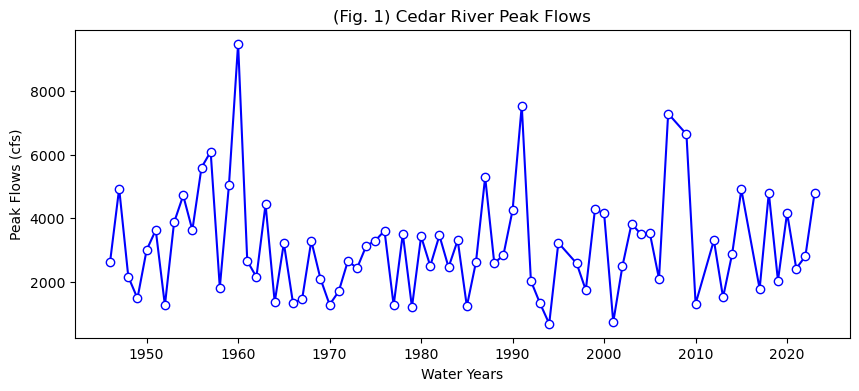

In [14]:
# Create a new figure.

# create water years
plt.figure(figsize=(10,4))

# Use the plot() function to plot the year on the x-axis, peak flow values on
# the y-axis with an open circle representing each peak flow value.
plt.plot(skykomish_data['water year'], # our x value
         skykomish_data['peak value (cfs)'], # our y value
         linestyle='-', # plot a solid line
         color='blue', # make the line color blue
         marker='o', # also plot a circle for each data point
         markerfacecolor='white',  # make the circle face color white
         markeredgecolor='blue') # make the circle edge color blue

# Label the axes and title.
plt.xlabel('Water Years')
plt.ylabel('Peak Flows (cfs)')
plt.title('(Fig. 1) Cedar River Peak Flows');

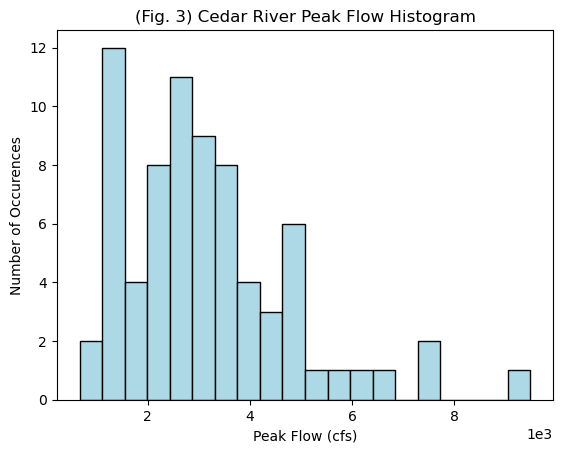

In [15]:
# Define the number of bins for the histogram. Try changing this number and running this cell again
nbins = 20

# Create a new figure.
plt.figure()

# Use the hist() function from matplotlib to plot the histogram
plt.hist(skykomish_data['peak value (cfs)'], nbins, ec="black", facecolor='lightblue')

# Labels and title
plt.title('(Fig. 3) Cedar River Peak Flow Histogram')
plt.xlabel('Peak Flow (cfs)')
plt.ylabel('Number of Occurences')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0)) # formatting the x axis to use scientific notation

**Probability distributions**
We seldom have enough data to directly determine the 100-year flood, so we plot our data and assess what distribution we think it came from.  Open the probability-distributions.ipynb file and look at the different distributions.

**Which do you think best matches the histogram plotted above?  Could we consider this a normal distribution?**

### Sample Mean, Variance, Standard Deviation, Skew:

We just have a sample from the population, and can calculate the mean, variance, standard deviation, and skew as follows:

**Sample Mean:** [`np.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)

$\bar{X} = \displaystyle\sum_{i=1}^{n} \frac{X_i}{n}$



**Sample Variance:** [`np.var(...,ddof=1)`](https://numpy.org/doc/stable/reference/generated/numpy.var.html)

$\sigma^{2} = \displaystyle\sum_{i=1}^{n} \frac{(X_i - \bar{X})^2}{(n-1)}$


**Sample Standard Deviation:** [`np.std(...,ddof=1)`](https://numpy.org/doc/stable/reference/generated/numpy.var.html)

$\sigma = \sqrt{\sigma^2}$


**Sample Skew:** [`stats.skew(...,ddof=1)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)

$G_s = n\displaystyle\sum_{i=1}^{n} \frac{(X_i - \bar{X})^2}{(n-1)(n-2)\sigma^3}$

(See Ch. 1 of Helsel et al., 2020)

## Method 1:  Log-Pearson III
The USGS recommends that the Log-Pearson III (LP3) distribution be used for all official flood analysis.
* Take $log_{10}$ of all of the instantaneous maximum annual flood values.
* Using the log dataset, calculate the mean, standard deviation, and skew
* Look up K as a function of the return period of interest and the calculated skew.  (Note that there are a lot of details into how K can also be regionally adjusted based on the skew calculated for other streams in the region.  We will neglect this for now and use Appendix 3 from the USGS Bulletin17b.)
* Calculate $log⁡(Q_{Tr})= mean(log⁡Q)+K\sigma_{logQ}$, where $K$ is a function of the return period and the skew.
* Convert from log back to the predicted Q at that return interval.

In [16]:
# With out dataset
logdata = np.log10(skykomish_data['peak value (cfs)'])
meanlogdata = np.mean(logdata)
print(meanlogdata)
stdlogdata = np.std(logdata)
print(stdlogdata)
skewlogdata = stats.skew(logdata)
print(skewlogdata)

3.4389764280297173
0.23322886752459607
-0.27033623593776523


Now we have to look up K for the 100 year flood and a -0.27 skew.  Here is a snapshot for the page relevant to our skew.
![Bulletin2](Bulletin17b_appendix3_K_skykomish.png)

For the 100 year flood, we look up a 1%, 0,.01, exceedance probability.  We round -0.27 to -0.3.  I get that K = 2.10394.

In [17]:
# So we plug this into the formula
K=2.10394
logQ100 = meanlogdata + K*stdlogdata
#and convert back from log space
Q100 = 10**(logQ100)
print(Q100)

8505.032383722348


So, note that by the Log-Pearson III method, we calculate the 100-year flood at 8,505 cfs.

# Method 2:  Plot the data according to an assumed distribution and extrapolate to the desired value
**Now we need to sort our data and assign a flood return probability.**
For this class, we will use the Weibull plotting position.  Note that there are multiple approaches on how to calculate plotting and extreme value probability.  More will be covered in Hydrology and Advanced Hydrology classes.

**Step 1** Rank the data from highest to lowest flows

In [18]:
# Rank all our values
df = skykomish_data
column_name = 'peak value (cfs)'
ranked_df = df.sort_values(by=[column_name], ascending=False).reset_index()
     
# preview the dataframe
ranked_df.head(3)   

,index,gage_ID,date of peak,water year,peak value (cfs),gage_ht (feet)
0,14,12115000,1959-11-22,1960,9490.0,11.34
1,45,12115000,1990-11-25,1991,7540.0,10.38
2,60,12115000,2006-11-06,2007,7290.0,9.47


**Step 2** Estimate the probability of exceedence using the Weibull Order
$$ P(Q>x) = \frac{m}{n+1} $$
where $x$ is the observed flow value, $m$ is the rank order,
and $n$ is the total length of the record

In [19]:
 # Calculate the Weibull plotting position
ranked_df['weibull_plotting_position'] = (ranked_df.index + 1) / (ranked_df[column_name].count() + (1))
# where we add the 1 in the top line because the ranked index starts at 0
     
ranked_df.head(3)

,index,gage_ID,date of peak,water year,peak value (cfs),gage_ht (feet),weibull_plotting_position
0,14,12115000,1959-11-22,1960,9490.0,11.34,0.013333
1,45,12115000,1990-11-25,1991,7540.0,10.38,0.026667
2,60,12115000,2006-11-06,2007,7290.0,9.47,0.040000


Note that the highest flow observed in our record, 9,490 cfs, is higher than the predicted 100 year flood by method 1.

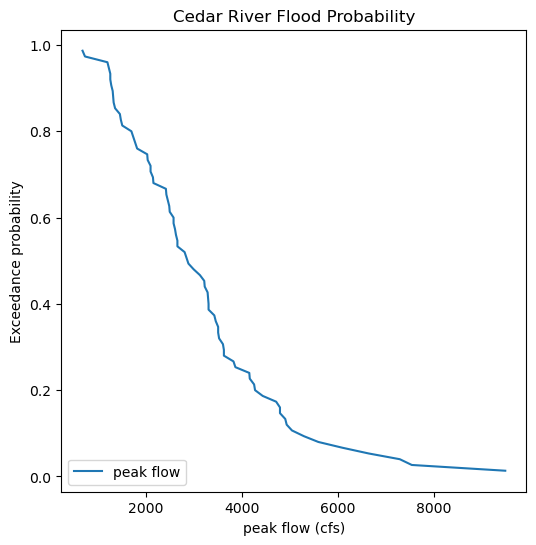

In [20]:
# create a figure and specify its size
plt.figure(figsize=(6,6))

plt.plot(ranked_df['peak value (cfs)'],ranked_df['weibull_plotting_position'], label='peak flow')

plt.legend(loc='lower left')                   # add a legend to the lower left of the figure
plt.xlabel('peak flow (cfs)')               # set the label for the x axis
plt.ylabel('Exceedance probability')                             # set the label for the y axis
plt.title('Cedar River Flood Probability');          # give our plot a title

Re-do this plot as a function of return period on the x-axis with a log scale

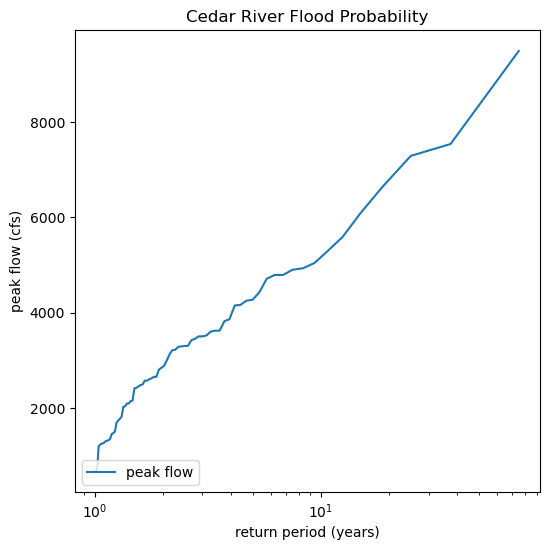

In [21]:
# create a figure and specify its size
plt.figure(figsize=(6,6))

plt.plot(1/ranked_df['weibull_plotting_position'], ranked_df['peak value (cfs)'], label='peak flow')

plt.legend(loc='lower left')                   # add a legend to the lower left of the figure
plt.ylabel('peak flow (cfs)')               # set the label for the x axis
plt.xlabel('return period (years)')                             # set the label for the y axis
plt.title('Cedar River Flood Probability');          # give our plot a title
plt.xscale('log')

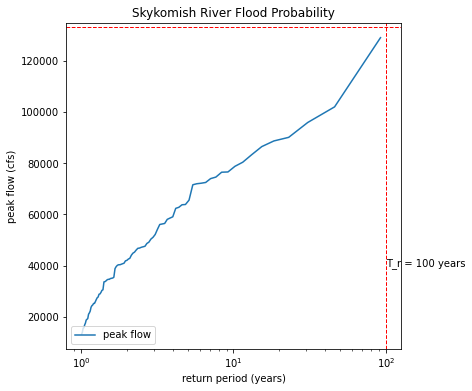

In [37]:
# And read off the plot the value that corresponds to a 100 year return period (10^2)
fig, ax = plt.subplots(figsize=(6,6))


ax.plot(1/ranked_df['weibull_plotting_position'], ranked_df['peak value (cfs)'], label='peak flow')
ax.axvline(100, linestyle='--', color='r', lw=1)
ax.text(100,40000,'T_r = 100 years')
ax.axhline(133000, linestyle='--', color='r', lw=1)

ax.legend(loc='lower left')                   # add a legend to the lower left of the figure
ax.set_ylabel('peak flow (cfs)')               # set the label for the y axis
ax.set_xlabel('return period (years)')                             # set the label for the x axis
ax.set_title('Skykomish River Flood Probability');          # give our plot a title
ax.set_xscale('log')

The idea is that we want to extrapolate our data to the 100 year reutrn period, as marked by the red dashed lines above.  We would read the peak flow value that corresponds to the 100 year return period on the plot.  The problem is that extrapolation that is not linear is tricky. These data do not plot on a line on a log scale. So we try to find a distribution to fit our data to.  If we plot our data on special probability paper (or with a special computer program knowing that distribution), then it should plot on a straight line.

**Now we want to see if the Weibull distribution is a good fit**
The Weibull distribution is commonly used in exceedence probabilities and risk analysis. If our data fit the Weibull distribution, we can use it to estimate our 100 year flood value.


Text(0.5, 0, 'Discharge (cfs)')

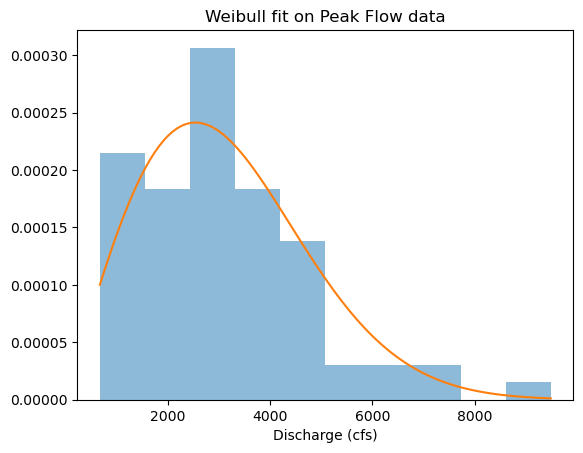

In [22]:
from scipy.stats import weibull_min
plt.hist(ranked_df['peak value (cfs)'], density=True, alpha=0.5)
shape, loc, scale = weibull_min.fit(ranked_df['peak value (cfs)'], floc=0)
x = np.linspace(ranked_df['peak value (cfs)'].min(), ranked_df['peak value (cfs)'].max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x))
plt.title("Weibull fit on Peak Flow data")
plt.xlabel("Discharge (cfs)")

Text(0.5, 1.0, 'Weibull probability plot of peak flow data')

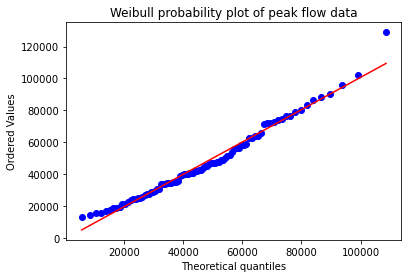

In [22]:
from scipy.stats import probplot, weibull_min
shape, loc, scale = weibull_min.fit(ranked_df['peak value (cfs)'], floc=0)
probplot(ranked_df['peak value (cfs)'], \
dist=weibull_min(shape,loc,scale),\
plot=plt.figure().add_subplot(111))
plt.title("Weibull probability plot of peak flow data")

The above plot, called a Q-Q plot (which shows observed vs. theoretical quantiles), is a way to determine if our distribution is a good fit.  If it is a good fit, the data will plot on a straight line.  Here we see that most of our data plot on that line, but our largest flood does not.  This indicates that for the most extreme values, the Weibull distribution might not be the best.

---
For comparison with the Log-Pearson Method (part 1), we can ask the computer to output the highest 1% of the Weibull distribution.  (With modern day computers, this is faster than doing this graphically.)

0.9909097188720392


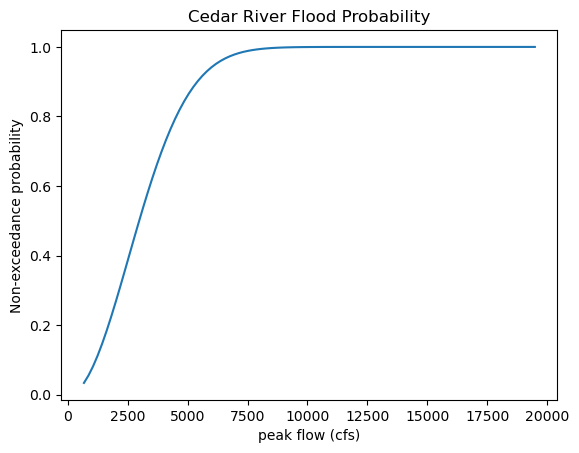

In [31]:
# Plot a cumulative distribution function of the weibull distribution fitted to our data
x = np.linspace(ranked_df['peak value (cfs)'].min(), ranked_df['peak value (cfs)'].max()+10000, 100)
plt.plot(x, weibull_min(shape, loc, scale).cdf(x))
plt.xlabel('peak flow (cfs)')               # set the label for the x axis
plt.ylabel('Non-exceedance probability')    # set the label for the y axis
plt.title('Cedar River Flood Probability');

# The 99% probability of non-exceedance corresponds to a 1% probability of exceedance
# Through trial and error, we find that a flow of 9,490 cfs corresponds here.
# This is less than the highest flow we observed, which could mean our highest flow was greater than a 100 year
# flood or that we chose the wrong distribution. 
output = weibull_min(shape, loc, scale).cdf(7700)
print(output)

# Summary and Discussion
Note that assuming a Weibull distribution, we would predict the 100 year flood to be about 7,700 cfs.
The Q-Q plot suggested that our highest peak did not fall on a Weibull distribution.
The Log-Pearson III distribution, recommended by the USGS and US government, predicts the 100 year flood to be 8,505 cfs.  
Our largest flood of record is 9,490 cfs.  It likely has a greater return period than 100 years, suggesting that is has less than 1% probability of occurring any given year.

You will want to use this code to do Homework 5, problem 2.  Note that the plotting fits in Method 2 were done by eye.  This is fine, you can iterate on values in the code to find what looks right to you.